In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read Training Set
train = pd.read_csv('Data/train.csv',parse_dates=['click_time'])

In [3]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [4]:
train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

In [5]:
# get day 7 and day 8
train_2days = train[train['day'].isin([7,8])]
train_2days.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
9308568,70712,2,1,32,237,2017-11-07,NaN,0,7,0,0,0
9308569,45892,3,1,25,424,2017-11-07,NaN,0,7,0,0,0
9308570,37774,8,2,13,145,2017-11-07,NaN,0,7,0,0,0
9308571,41179,2,1,13,122,2017-11-07,NaN,0,7,0,0,0
9308572,83111,15,1,8,245,2017-11-07,NaN,0,7,0,0,0


In [7]:
train_2days.shape

(122578385, 12)

In [6]:
# train_2days['minute'] = train_2days['minute'].apply(lambda x: '{0:0>2}'.format(x))

<ipython-input-6-d67172e86897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['minute'] = train_2days['minute'].apply(lambda x: '{0:0>2}'.format(x))


In [8]:
ranges = [-1, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, np.inf]  # np.inf for infinity
labels = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
train_2days['seconds_5'] = pd.cut(train_2days['second'],
                                  bins=ranges,
                                  labels=labels)

<ipython-input-8-48717335939d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['seconds_5'] = pd.cut(train_2days['second'],


In [9]:
train_2days['hm_seconds_5'] = train_2days['hour'].astype(str) + train_2days['minute'].astype(str) + train_2days['seconds_5'].astype(str)
train_2days['hm_seconds_5'] = train_2days['hm_seconds_5'].astype('int32')


<ipython-input-9-cc80397a914f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['hm_seconds_5'] = train_2days['hour'].astype(str) + train_2days['minute'].astype(str) + train_2days['seconds_5'].astype(str)
<ipython-input-9-cc80397a914f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['hm_seconds_5'] = train_2days['hm_seconds_5'].astype('int32')


In [10]:
conversion_seconds_5 = train_2days.groupby('hm_seconds_5').aggregate(
                        {
                            'is_attributed':sum,
                            'click_time':"count"
                        }
                    )

conversion_seconds_5['conversion_rate'] = conversion_seconds_5['is_attributed']/conversion_seconds_5['click_time']
conversion_seconds_5.reset_index(level=0, inplace=True)

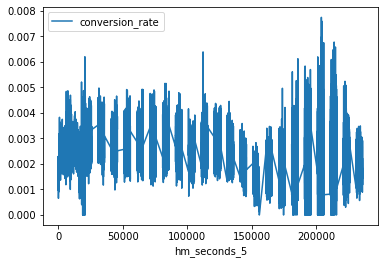

In [11]:
conversion_seconds_5.plot(x ='hm_seconds_5', y='conversion_rate', kind = 'line')
plt.show()

In [12]:
df = conversion_seconds_5
df.loc[(df['is_attributed'] != 0), 'threshold'] = df['click_time']/df['is_attributed']

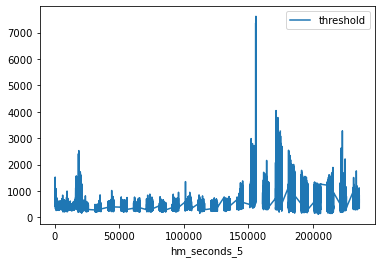

In [13]:
df.plot(x ='hm_seconds_5', y='threshold', kind = 'line')
plt.show()

In [14]:
co = conversion_seconds_5[conversion_seconds_5['conversion_rate']==0]
Q1 = co.click_time.quantile(0.25)
Q3 = co.click_time.quantile(0.75)
IQR = Q3 - Q1
click_outlier = Q3 + 1.5 * IQR
print("Number of clicks threshold: ", click_outlier)

Number of clicks threshold:  2076.875


In [15]:
Q1 = df.threshold.quantile(0.25)
Q3 = df.threshold.quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
print("Clicks squared per downloads threshold: ", threshold)

Clicks squared per downloads threshold:  828.4777506265665


In [16]:
df.loc[(df['is_attributed'] == 0) & (df['click_time'] > click_outlier), 'isFraud'] = 1
df.loc[(df['is_attributed'] != 0) & (df['threshold'] > threshold), 'isFraud'] = 1
df.loc[(df['isFraud'].isnull()), 'isFraud'] = 0

In [17]:
new_data = pd.merge(train_2days, df[['hm_seconds_5', 'isFraud']], on='hm_seconds_5', how='left')
new_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,seconds_5,hm_seconds_5,isFraud
0,70712,2,1,32,237,2017-11-07,NaN,0,7,0,0,0,01,1,0.0
1,45892,3,1,25,424,2017-11-07,NaN,0,7,0,0,0,01,1,0.0
2,37774,8,2,13,145,2017-11-07,NaN,0,7,0,0,0,01,1,0.0
3,41179,2,1,13,122,2017-11-07,NaN,0,7,0,0,0,01,1,0.0
4,83111,15,1,8,245,2017-11-07,NaN,0,7,0,0,0,01,1,0.0


In [18]:
event_rate = new_data.isFraud.sum()/len(new_data)
print("Event rate per 5 seconds using clicks per downloads threshold: ", event_rate)

Event rate per 5 seconds using clicks per downloads threshold:  0.04303874618677673


In [19]:
new_data.shape

(122578385, 15)

In [20]:
new_data.ip.describe()

count    1.225784e+08
mean     8.914667e+04
std      6.465513e+04
min      1.000000e+00
25%      4.021600e+04
50%      7.973400e+04
75%      1.184750e+05
max      3.647760e+05
Name: ip, dtype: float64

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
ip = new_data['ip'].values
new_data['ip'] = sc.fit_transform(ip.reshape(-1, 1))
new_data.ip.describe()

count    1.225784e+08
mean    -8.178511e-14
std      1.000000e+00
min     -1.378787e+00
25%     -7.567948e-01
50%     -1.455827e-01
75%      4.536119e-01
max      4.263070e+00
Name: ip, dtype: float64

In [26]:
x = new_data.drop(['click_time', 'attributed_time', 'is_attributed', 'seconds_5', 'hm_seconds_5', 'isFraud'], axis=1)
y = new_data['isFraud'].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 4)
rf.fit(x_train, y_train)
rf_yhat = rf.predict(x_test)

In [ ]:
print("Model accuracy score: ", accuracy_score(y_test, rf_yhat))

In [ ]:
rf_matrix = confusion_matrix(y_test, rf_yhat, labels = [0, 1])